In [1]:
%cd ../src
import pickle
import pandas as pd
from utils import IMAGE_TYPES, RDF_DATE_TYPES, RDF_NUMBER_TYPES, POTENTIAL_TEXT_TYPES, RDF_DATE_TYPES, get_relevant_relations
import matplotlib.pyplot as plt

e:\00_CODE\03_Master_Thesis\rdf-literal-preprocessing\src


c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataset(dataset):
    with open(f"../data/raw/{dataset}_final_torch_None.pickle", "rb") as f:
        data = pickle.load(f)
    
    print("# nodes")
    print(len(data.i2e))
    print("datatypes")
    print(data.datatypes())
    return data

In [27]:
#from dataload import amplus

data = load_dataset('amplus')


# nodes
1153221
datatypes
['iri', 'blank_node', 'none', 'http://kgbench.info/dt#base64Image', 'http://www.w3.org/2001/XMLSchema#date', 'http://www.w3.org/2001/XMLSchema#decimal', 'http://www.w3.org/2001/XMLSchema#positiveInteger']


In [28]:
relevent_relations = get_relevant_relations(
    data, relevant_types=POTENTIAL_TEXT_TYPES)

In [29]:
from preprocess.topics import get_stopword_list, remove_stopwords
stopword_list = get_stopword_list()

In [30]:
min_mean_word_count = 3
import gensim
from gensim.utils import simple_preprocess
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

In [34]:
import gensim.corpora as corpora
import re
i=0
for r in relevent_relations:
    df = pd.DataFrame(data.triples[data.triples[:,1]== r], columns=['s','p','o'])
    df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
    df['type'] = df['o'].apply(lambda t: data.i2e[t][1])

    # delete "none type" polygons 
    df['text'] = df['text'].apply(lambda t:'' if re.match('(MULTIPOLYGON|POLYGON)',t) else t)
    mean_num_words = df['text'].str.count(r'([\w\:\.\/]{3,})').mean()
    #print(mean_num_words)
    if mean_num_words > min_mean_word_count:
        i+=1
        df['text_preprocessed'] = df['text'].apply(lambda t: gensim.utils.simple_preprocess(t, deacc=True))
        df['text_preprocessed'] = df['text_preprocessed'].apply(lambda t: remove_stopwords(t, stopword_list=stopword_list))

        data_words = df.text_preprocessed.values.tolist()
        print(data_words[:1][0][:30])
        # Create Dictionary
        id2word = corpora.Dictionary(data_words)
        # Term Document Frequency
        corpus = [id2word.doc2bow(text) for text in data_words]
        print(corpus[:1][0][:30])
        print(r)
        print(data.i2r[r])
        num_topics = 10
        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                            iterations=100,
                                id2word=id2word,
                                num_topics=num_topics,
                                random_state=42)
        if i>1:
            break
        
        

['rijk', 'gekleed']
[(0, 1), (1, 1)]
17
http://purl.org/collections/nl/am/exhibitionTitle
['geboren', 'luik', 'overleden', 'amsterdam', 'verbleef', 'jeugd', 'korte', 'tijd', 'rome', 'luik', 'opgeleid', 'bertholet', 'flemalle', 'vestigde', 'voorgoed', 'amsterdam', 'vroegste', 'werk', 'overdadig', 'barok', 'later', 'belargrijkste', 'hollandse', 'classicisme', 'trant', 'schilderde', 'plafonds', 'meestal', 'allegorische', 'mythologische']
[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
0
http://purl.org/collections/nl/am/biography


In [ ]:
pyLDAvis.

In [35]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'lda.html')
vis

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.025779 -0.048551       1        1  16.816401
7      0.054121 -0.003883       2        1  16.594730
6     -0.007607 -0.120972       3        1  14.050693
8      0.032175 -0.039098       4        1  12.681283
2     -0.097087  0.062144       5        1   8.608615
0     -0.047557 -0.028478       6        1   7.869998
3     -0.002983  0.017601       7        1   7.194105
9      0.055022  0.050644       8        1   5.740707
1     -0.068998  0.060663       9        1   5.518657
5      0.108693  0.049930      10        1   4.924811, topic_info=            Term        Freq       Total Category  logprob  loglift
121   zilversmid  213.000000  213.000000  Default  30.0000  30.0000
120     werkzaam  253.000000  253.000000  Default  29.0000  29.0000
338       regent  121.000000  121.000000  Default  28.0000  28.0000
85    medailleur   70.000000   70.000000  Default  27.0000  27.0000
109     schilder  111.000000  111.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
226        vanaf    2.767408   73.590098  Topic10  -5.5604  -0.2697
86        aldaar    2.454294   55.703389  Topic10  -5.6805  -0.1113
2196   catharina    2.055139   26.255878  Topic10  -5.8580   0.4633
74    portretten    2.054992   47.518235  Topic10  -5.8580  -0.1300
968         raad    2.054895   43.455366  Topic10  -5.8581  -0.0406

[767 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2389      1  0.305688  aalmoezeniers
2389      7  0.458532  aalmoezeniers
2389      8  0.152844  aalmoezeniers
125       2  0.092602         acteur
125       4  0.092602         acteur
...     ...       ...            ...
408       9  0.031886           zoon
408      10  0.031886           zoon
2139      6  0.460527            zus
1338      3  0.726346        zutphen
141       6  0.555218         zwolle

[1598 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 8, 7, 9, 3, 1, 4, 10, 2, 6])

In [ ]:


stopword_list = get_stopword_list()
    for r in relevent_relations:
        df = pd.DataFrame(data.triples[data.triples[:,1]== r], columns=['s','p','o'])
        df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
        df['type'] = df['o'].apply(lambda t: data.i2e[t][1])
    
        # delete "none type" polygons 
        df['text'] = df['text'].apply(lambda t:'' if re.match('(MULTIPOLYGON|POLYGON)',t) else t)
        mean_num_words = df['text'].str.count(r'([\w\:\.\/]{3,})').mean()
        #print(mean_num_words)
        if mean_num_words > min_mean_word_count:




            df['text_preprocessed'] = df['text'].apply(lambda t: gensim.utils.simple_preprocess(t, deacc=True))
            df['text_preprocessed'] = df['text_preprocessed'].apply(lambda t: remove_stopwords(t, stopword_list=stopword_list))

            data_words = df.text_preprocessed.values.tolist()
            #data_words = list(sent_to_words(text_data))
            print(data_words[:1][0][:30])
            # Create Dictionary
            id2word = corpora.Dictionary(data_words)
            # Term Document Frequency
            corpus = [id2word.doc2bow(text) for text in data_words]
            print(corpus[:1][0][:30])
            num_topics = 10
            lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                                   iterations=100,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=42)
            df['vector'] = df['text_preprocessed'].apply(lambda t: id2word.doc2bow(t))
            df['topics'] = df['vector'].apply(lambda t: [x[0] for x in sorted(lda_model.get_document_topics(t), key=lambda x: x[1], reverse=True)[:3] if x[1]>0.1])
            for i in range(num_topics):
                df[f'topic_{i}'] = df['topics'].apply(lambda t: True if i in t else False)
        
            for i in range(num_topics):

                sub = df[df[f'topic_{i}']==True]
                if  len(sub)> 0:
                    sub_df = torch.zeros(len(sub),3,dtype=torch.int32)
                    sub_df[:,0] = torch.tensor(sub.s.tolist(), dtype=torch.int32)
                    #torch.full((len(sub),1),data.r2i[f'{URI_PREFIX}predicat#topics{9}'], dtype=torch.int32)
                    sub_df[:,1] = data.r2i[f'{URI_PREFIX}predicat#topics{r}']
                    sub_df[:,2] = data.e2i[f'{URI_PREFIX}entity#topic{i}', f'{URI_PREFIX}datatype#topics']
                    data.triples = torch.cat((data.triples, sub_df), 0)
    #data = delete_empty_bin_types(data,num_topics)
    return data

In [4]:
from preprocess import append_date_features, bin_dates
from preprocess import LDA_topic_assignment

In [5]:
data = LDA_topic_assignment(data)

['exterieur', 'overzicht', 'voorgevel', 'kleine', 'gebouw', 'links', 'midden', 'wachtkamer', 'apotheek']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
['dusselsma']
[(0, 1)]


In [16]:
data

In [17]:
data.triples

tensor([[185557,    131, 127327],
        [182860,     25, 119738],
        [207157,     45, 293297],
        ...,
        [239918,    163, 350053],
        [234493,    163, 350053],
        [136941,    163, 350053]], dtype=torch.int32)

In [18]:
data.i2e[350053]

('http://multimodal-knowledge-graph-augmentation.com/entity#topic9',
 'http://multimodal-knowledge-graph-augmentation.com/datatype#topics')

In [188]:
df

,s,p,o,t
0,123242,13,11440,1915617280
1,123293,13,10438,1506344960
2,123421,13,11696,-330366976
3,123510,13,11374,-543293440
4,123524,13,11244,-1510408192
...,...,...,...,...
9501,689169,13,11211,-707133440
9502,689203,13,11689,-215613440
9503,689268,13,9102,-1623195648
9504,689313,13,11244,-1510408192


In [8]:
from preprocess.binning import encode_number_sublist

In [145]:
data.name

'mdgenre'

In [20]:
import pandas as pd
from utils import Data,  RDF_DATE_TYPES
import datetime
import numpy as np

URI_PREFIX ="test"

df = data.triples
rr = get_relevant_relations(data, RDF_DATE_TYPES)
#sub_df = encode_number_sublist(df.triples[df.triples[:,1]== rr[0]])
# for r in rr:
#     dfs = []
#     for triple in df[df[:,1] ==r]:
#         dfs.append(pd.DataFrame([[int(triple[0]), data.i2e[triple[2]][0].split('+')[0]]], columns = ["s","date"]))
#     frame = pd.concat(dfs)
#     frame.date = frame.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S') if type(x)==str else np.NaN)
#     frame["weekday"] = frame.date.apply(lambda x: x.strftime('%A') if x != np.NaN else np.NaN)
#     frame["month"] = frame.date.apply(lambda x: x.strftime('%B') if x != np.NaN else np.NaN)
#     break
    # for _, row in frame.iterrows():
    #     s = data.i2e[row['s']]
    #     p_week = f'{URI_PREFIX}predicat#dates-weekday-{r}'
    #     o_week = (f'{URI_PREFIX}entity#dates-weekday-{row["weekday"]}',f'{URI_PREFIX}datatype#weekday')
    #     p_month = f'{URI_PREFIX}predicat#dates-month-{r}'
    #     o_month = (f'{URI_PREFIX}entity#dates-month-{row["month"]}',f'{URI_PREFIX}datatype#month')
    #     data = add_triple(data,s,p_week,o_week)
    #     data = add_triple(data,s,p_month,o_month)

In [21]:
rr

[13, 14, 1, 6, 3, 21, 22]

In [174]:
df['t'].values[1].astype('int')

-560005120

In [173]:
import time
time.mktime(df['t'].values[1])

TypeError: Tuple or struct_time argument required

In [155]:
relevent_relations

[117, 63, 120, 119, 64, 16, 12]

In [23]:
relation = rr[0]
relevent_relations = rr

date_features =  ['day_of_month','day_of_week','month_of_year','quarter_of_year','year']
feature_ranges = {
    'day_of_week' : ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"],
    'month_of_year' : ["01","02","03","04","05","06","07","08","09","10","11","12"],
    'quarter_of_year' : ['1',"2","3","4"]
}
from utils import add_triple
import torch

In [30]:


if f'{URI_PREFIX}predicat#prevDate' not in data.r2i:
    p = f'{URI_PREFIX}predicat#prevDate'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1

    p = f'{URI_PREFIX}predicat#nextDate'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1

for r in relevent_relations:
    for feature in date_features:
        p = f'{URI_PREFIX}predicat#aug_date_{r}_{feature}'
        new_id = len(data.i2r)
        data.r2i[p] = new_id
        data.i2r.append(p)
        data.num_relations += 1

for relation in relevent_relations:
    for feature in date_features:
        if feature in feature_ranges:
            for i in range(len(feature_ranges[feature])):
                entry = feature_ranges[feature][i]
                o = (f'{URI_PREFIX}entity#{feature}{entry}-relation{relation}',
                    f'{URI_PREFIX}datatype#feature')
                new_id = len(data.i2e)
                data.e2i[o] = new_id
                data.i2e.append(o)
                data.num_entities += 1
                if i > 0:
                    prev_o = (f'{URI_PREFIX}entity#{feature}{feature_ranges[feature][i-1]}-relation{relation}',
                    f'{URI_PREFIX}datatype#feature')
                    data = add_triple(data, o, f'{URI_PREFIX}predicat#prevDate', prev_o)
                    data = add_triple(data, prev_o, f'{URI_PREFIX}predicat#nextDate', o)

    df = pd.DataFrame(data.triples[data.triples[:,1]== relation], columns = ["s","p","o"])
    df['t'] = df['o'].apply(lambda x: data.i2e[x][0])
    df['t']= pd.to_datetime(df['t'],errors='coerce')
    df = df[df['t'].notnull()]
    df['day_of_month'] = df['t'].apply(lambda x: str(x.strftime('%d')) if not pd.isnull(x) else "")
    df['day_of_week'] = df['t'].apply(lambda x: str(x.strftime('%A')) if not pd.isnull(x) else "")
    df['month_of_year'] = df['t'].apply(lambda x: str(x.strftime('%m')) if not pd.isnull(x) else "")
    df['quarter_of_year'] = df['t'].apply(lambda x: str(((int(x.strftime('%m'))-1)//4)+1) if not pd.isnull(x) else "")
    df['year'] = df['t'].apply(lambda x: str(x.strftime('%Y')) if not pd.isnull(x) else "")
    if relation == 13:
        break
    for feature in date_features:
        if feature not in feature_ranges:
            for f in df[df[feature].notnull()][feature].unique():
                o = (f'{URI_PREFIX}entity#{feature}{f}-relation{relation}',
                f'{URI_PREFIX}datatype#feature')
                new_id = len(data.i2e)
                data.e2i[o] = new_id
                data.i2e.append(o)
                data.num_entities += 1

    for feature in date_features:
        # if feature in feature_ranges:
            
        df['new_o'] = df[feature].apply(lambda f: data.e2i[(f'{URI_PREFIX}entity#{feature}{f}-relation{relation}',
                f'{URI_PREFIX}datatype#feature')] if not pd.isnull(f) else f)
        df['new_p'] = df[feature].apply(lambda f: data.r2i[f'{URI_PREFIX}predicat#aug_date_{relation}_{feature}'] if not pd.isnull(f) else f)
        ten = torch.tensor(df[df['new_o'].notnull()][['s','new_p','new_o']].values.astype(np.int32), dtype= torch.int32)
        data.triples = torch.cat((data.triples, ten), 0)
    
    13
        # else:
        #     for _,entry in df[df[feature].notnull()][['s',feature]].iterrows():
        #         o = (f'{URI_PREFIX}entity#{feature}{entry[feature]}-relation{relation}',
        #             f'{URI_PREFIX}datatype#feature')
        #         if o not in data.i2e:
        #             new_id = len(data.i2e)
        #             data.e2i[o] = new_id
        #             data.i2e.append(o)
        #             data.num_entities += 1
                
        #         data = add_triple(data, data.i2e[entry["s"]], f'{URI_PREFIX}predicat#aug_date_{relation}_{feature}', o)

         
        #         #data = add_triple()




In [31]:
df["day_of_month"].unique()

array(['22', '28', '25', '02', '13', '31', '03', '06', '10', '07', '26',
       '19', '01', '16', '30', '23', '04', '09', '15', '14', '05', '17',
       '18', '11', '21', '20', '24', '27', '12', '29', '08'], dtype=object)

In [28]:
day_of_month

['http://purl.org/collections/nl/am/biography',
 'http://purl.org/collections/nl/am/birthDateEnd',
 'http://purl.org/collections/nl/am/birthPlace',
 'http://purl.org/collections/nl/am/currentLocationDateEnd',
 'http://purl.org/collections/nl/am/currentLocationNotes',
 'http://purl.org/collections/nl/am/currentLocationType',
 'http://purl.org/collections/nl/am/deathDateEnd',
 'http://purl.org/collections/nl/am/deathPlace',
 'http://purl.org/collections/nl/am/dimension',
 'http://purl.org/collections/nl/am/dimensionType',
 'http://purl.org/collections/nl/am/dimensionUnit',
 'http://purl.org/collections/nl/am/dimensionValue',
 'http://purl.org/collections/nl/am/exhibition',
 'http://purl.org/collections/nl/am/exhibitionDateEnd',
 'http://purl.org/collections/nl/am/exhibitionDateStart',
 'http://purl.org/collections/nl/am/exhibitionLref',
 'http://purl.org/collections/nl/am/exhibitionOrganiser',
 'http://purl.org/collections/nl/am/exhibitionTitle',
 'http://purl.org/collections/nl/am/exhib

In [161]:
df

,s,p,o,t,day_of_month,day_of_week,month_of_year,quarter_of_year,year
0,852211,1,3567,NaT,NaT,NaT,NaT,NaT,NaT
1,852412,1,6439,1864-08-25,0 days 00:00:00.000000025,Thursday,0 days 00:00:00.000000008,2,0 days 00:00:00.000001864
2,852492,1,7989,1952-01-01,0 days 00:00:00.000000001,Tuesday,0 days 00:00:00.000000001,1,0 days 00:00:00.000001952
3,852569,1,6859,1887-05-28,0 days 00:00:00.000000028,Saturday,0 days 00:00:00.000000005,2,0 days 00:00:00.000001887
4,852654,1,2285,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...
3318,917504,1,7525,1921-04-25,0 days 00:00:00.000000025,Monday,0 days 00:00:00.000000004,1,0 days 00:00:00.000001921
3319,918167,1,7865,1943-07-25,0 days 00:00:00.000000025,Sunday,0 days 00:00:00.000000007,2,0 days 00:00:00.000001943
3320,918783,1,5345,1797-04-18,0 days 00:00:00.000000018,Tuesday,0 days 00:00:00.000000004,1,0 days 00:00:00.000001797
3321,918963,1,7641,1929-10-07,0 days 00:00:00.000000007,Monday,0 days 00:00:00.000000010,3,0 days 00:00:00.000001929


In [165]:
df.t

0             NaT
1      1864-08-25
2      1952-01-01
3      1887-05-28
4             NaT
          ...    
3318   1921-04-25
3319   1943-07-25
3320   1797-04-18
3321   1929-10-07
3322   1837-01-01
Name: t, Length: 3323, dtype: datetime64[ns]

In [170]:
df.t.apply(lambda x: x.strftime('%d') if not pd.isnull(x) else np.datetime64('nat'))

0       NaT
1        25
2        01
3        28
4       NaT
       ... 
3318     25
3319     25
3320     18
3321     07
3322     01
Name: t, Length: 3323, dtype: object

In [176]:
num_bins = 10

In [210]:
if f'{URI_PREFIX}predicat#prevDate' not in data.r2i:
    p = f'{URI_PREFIX}predicat#prevDate'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1

    p = f'{URI_PREFIX}predicat#nextDate'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1

for relation in relevent_relations:
    p = f'{URI_PREFIX}predicat#bin_date_{relation}'
    new_id = len(data.i2r)
    data.r2i[p] = new_id
    data.i2r.append(p)
    data.num_relations += 1

for relation in relevent_relations:

    for i in range(num_bins):
        # entry = feature_ranges[feature][i]
        o = (f'{URI_PREFIX}entity#{i+1}-relation{relation}',
            f'{URI_PREFIX}datatype#bin')
        new_id = len(data.i2e)
        data.e2i[o] = new_id
        data.i2e.append(o)
        data.num_entities += 1
        if i > 0:
            prev_o = (f'{URI_PREFIX}entity#{i}-relation{relation}',
            f'{URI_PREFIX}datatype#bin')
            data = add_triple(data, o, f'{URI_PREFIX}predicat#prevDate', prev_o)
            data = add_triple(data, prev_o, f'{URI_PREFIX}predicat#nextDate', o)

    df = pd.DataFrame(data.triples[data.triples[:,1]== relation], columns = ["s","p","o"])
    df['t'] = df['o'].apply(lambda x: data.i2e[x][0])
    df['t']= pd.to_datetime(df['t'],errors='coerce')
    df = df[df['t'].notnull()]
    df['t'] = df['t'].values.astype("int")

    df['bins'] = torch.from_numpy(  # get numpy solutions back
                np.digitize(  # assign for each value in sub_df the corresponding bin
                    df['t'].values, np.histogram(  # calculate n bins based on values in sub_df
                        df['t'].values, num_bins)[1][:-1]
                )
            ).reshape(-1, 1)  # transfrom x tensor into (x,1) tensor to fit (x,2) shape of sub_df
        
    
    df['new_o'] = df['bins'].apply(lambda x: data.e2i[(f'{URI_PREFIX}entity#{x}-relation{relation}',
            f'{URI_PREFIX}datatype#bin')])
    df['new_p'] = df['bins'].apply(lambda x: data.r2i[f'{URI_PREFIX}predicat#bin_date_{relation}'])
    ten = torch.tensor(df[(df['new_o'].notnull())][['s','new_p','new_o']].values.astype(np.int32), dtype= torch.int32)
    data.triples = torch.cat((data.triples, ten), 0)

    # object_mapping = np.vectorize(lambda t: data.e2i[(f'{URI_PREFIX}entity#{i}-relation{relation}',
    #         f'{URI_PREFIX}datatype#bin')])

    # predicat_mapping = np.vectorize(
    #     lambda t: data.r2i[f'{URI_PREFIX}predicat#bin_date_{relation}'])

    # augmented_df[:, 1] = torch.tensor(
    #     np.array([predicat_mapping(sub_df[:, 2])]), dtype=torch.int32)
    # # augmented_df[:, 2] = torch.tensor(
    # #     np.array([object_mapping(sub_df[:, 2])]), dtype=torch.int32)
    # data.triples = torch.cat((data.triples, augmented_df), 0)
   
    # df['day_of_month'] = df['t'].apply(lambda x: x.strftime('%d') if not pd.isnull(x) else x)
    # df['day_of_week'] = df['t'].apply(lambda x: x.strftime('%A') if not pd.isnull(x) else x)
    # df['month_of_year'] = df['t'].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else x)
    # df['quarter_of_year'] = df['t'].apply(lambda x: ((int(x.strftime('%m'))-1)//4)+1 if not pd.isnull(x) else x)
    # df['year'] = df['t'].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else x)

    # for feature in date_features:
    #     if feature not in feature_ranges:
    #         for f in df[df[feature].notnull()][feature].unique():
    #             o = (f'{URI_PREFIX}entity#{feature}{f}-relation{relation}',
    #             f'{URI_PREFIX}datatype#feature')
    #             new_id = len(data.i2e)
    #             data.e2i[o] = new_id
    #             data.i2e.append(o)
    #             data.num_entities += 1

    # for feature in date_features:
    #     # if feature in feature_ranges:
            
    #     df['new_o'] = df[feature].apply(lambda f: data.e2i[(f'{URI_PREFIX}entity#{feature}{f}-relation{relation}',
    #             f'{URI_PREFIX}datatype#feature')] if not pd.isnull(f) else f)
    #     df['new_p'] = df[feature].apply(lambda f: data.r2i[f'{URI_PREFIX}predicat#aug_date_{relation}_{feature}'] if not pd.isnull(f) else f)
    #     ten = torch.tensor(df[df[feature].notnull()][['s','new_p','new_o']].values.astype(np.int32), dtype= torch.int32)
    #     data.triples = torch.cat((data.triples, ten), 0)

In [208]:
data

In [209]:
df

,s,p,o,t,bins,new_o,new_p
0,992535,22,5083,1199243264,8,1153308,55
1,992545,22,4822,-1299120128,2,1153302,55
2,992546,22,5083,1199243264,8,1153308,55
3,992547,22,5068,433586176,7,1153307,55
4,992548,22,5068,433586176,7,1153307,55
...,...,...,...,...,...,...,...
58050,1065963,22,6162,-1453719552,2,1153302,55
58051,1065964,22,6162,-1453719552,2,1153302,55
58052,1065965,22,5507,1813708800,10,1153310,55
58053,1065966,22,5507,1813708800,10,1153310,55


In [205]:
df['bins'].unique()

array([10,  9,  5,  4,  2,  1,  3,  8,  6,  7], dtype=int64)

(array([ 741., 1443.,  659., 1208.,  657., 1046.,  366.,  837., 1072.,
        1477.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <BarContainer object of 10 artists>)

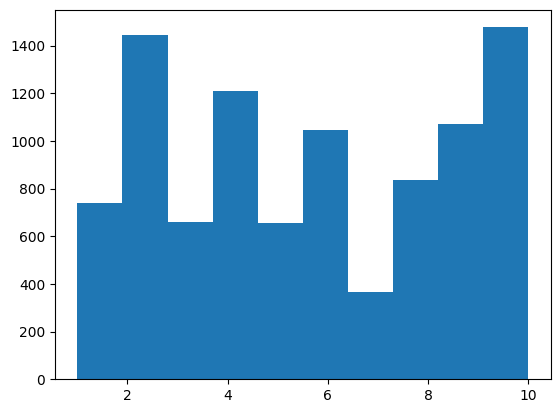

In [202]:
import matplotlib.pyplot as plt
plt.hist(df['bins'])

In [191]:
df

,s,p,o,t,bins
0,123242,13,11440,1915617280,10
1,123293,13,10438,1506344960,9
2,123421,13,11696,-330366976,5
3,123510,13,11374,-543293440,4
4,123524,13,11244,-1510408192,2
...,...,...,...,...,...
9501,689169,13,11211,-707133440,4
9502,689203,13,11689,-215613440,5
9503,689268,13,9102,-1623195648,2
9504,689313,13,11244,-1510408192,2


In [184]:
dfappend_date_features

,s,p,o,t
0,123242,13,11440,1915617280
1,123293,13,10438,1506344960
2,123421,13,11696,-330366976
3,123510,13,11374,-543293440
4,123524,13,11244,-1510408192
...,...,...,...,...
9501,689169,13,11211,-707133440
9502,689203,13,11689,-215613440
9503,689268,13,9102,-1623195648
9504,689313,13,11244,-1510408192


In [152]:
df['day_of_month']

0      15
1      26
2      16
3      25
4      14
       ..
134    17
135    28
136    19
137    01
138    23
Name: day_of_month, Length: 139, dtype: object

In [149]:
data.triples

tensor([[185557,    131, 127327],
        [182860,     25, 119738],
        [207157,     45, 293297],
        ...,
        [107428,    190, 350690],
        [259639,    190, 350679],
        [106127,    190, 350703]], dtype=torch.int32)

In [134]:
data.triples[data.triples[:,2]==350703]

tensor([[1155710,      34, 1155711],
        [1155712,      33, 1155711],
        [1007765,     103, 1155711],
        [1007767,     103, 1155711],
        [1017093,     103, 1155711],
        [1017104,     103, 1155711],
        [1018221,     103, 1155711],
        [1018224,     103, 1155711],
        [1018237,     103, 1155711],
        [1018279,     103, 1155711],
        [1018283,     103, 1155711],
        [1021827,     103, 1155711],
        [1021838,     103, 1155711],
        [1021849,     103, 1155711],
        [1021872,     103, 1155711],
        [1021883,     103, 1155711],
        [1021894,     103, 1155711],
        [1021905,     103, 1155711],
        [1021916,     103, 1155711],
        [1021927,     103, 1155711],
        [1021938,     103, 1155711],
        [1025867,     103, 1155711],
        [1026256,     103, 1155711],
        [1026300,     103, 1155711],
        [1027392,     103, 1155711],
        [1028288,     103, 1155711],
        [1029544,     103, 1155711],
 

In [150]:
data.i2e [350703]

('testentity#year1971-relation12', 'testdatatype#feature')

In [126]:
for year in df['year'].unique():
    print(year)
    break

1771


In [117]:
entry[1]['s']

992535

In [108]:
ten

tensor([[ 992535,     421, 1153431],
        [ 992545,     421, 1153433],
        [ 992546,     421, 1153431],
        ...,
        [1065965,     421, 1153432],
        [1065966,     421, 1153432],
        [1065973,     421, 1153431]], dtype=torch.int32)

In [106]:
df[df['day_of_month'].notnull()][['s','new_p']].values.astype(np.int32)

array([[ 992535,     386],
       [ 992545,     386],
       [ 992546,     386],
       ...,
       [1065965,     386],
       [1065966,     386],
       [1065973,     386]])

In [98]:
ten

tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=torch.int32)

In [77]:
df = pd.DataFrame(data.triples[data.triples[:,1]== rr[6]], columns = ["s","p","o"])
df['t'] = df['o'].apply(lambda x: data.i2e[x][0])
df['t']= pd.to_datetime(df['t'],errors='coerce')
df['day_of_month'] = df['t'].apply(lambda x: x.strftime('%d') if not pd.isnull(x) else x)
df['day_of_week'] = df['t'].apply(lambda x: x.strftime('%A') if not pd.isnull(x) else x)
df['month_of_year'] = df['t'].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else x)
df['quarter_of_year'] = df['t'].apply(lambda x: ((int(x.strftime('%m'))-1)//4)+1 if not pd.isnull(x) else x)
df['year'] = df['t'].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else x)
 

In [89]:
df

,s,p,o,t,day_of_month,day_of_week,month_of_year,quarter_of_year,year
0,992535,22,5083,1771-01-01,01,Tuesday,01,1,1771
1,992545,22,4822,1750-01-01,01,Thursday,01,1,1750
2,992546,22,5083,1771-01-01,01,Tuesday,01,1,1771
3,992547,22,5068,1770-01-01,01,Monday,01,1,1770
4,992548,22,5068,1770-01-01,01,Monday,01,1,1770
...,...,...,...,...,...,...,...,...,...
58050,1065963,22,6162,1840-01-01,01,Wednesday,01,1,1840
58051,1065964,22,6162,1840-01-01,01,Wednesday,01,1,1840
58052,1065965,22,5507,1800-01-01,01,Wednesday,01,1,1800
58053,1065966,22,5507,1800-01-01,01,Wednesday,01,1,1800


In [78]:
df

,s,p,o,t,day_of_month,day_of_week,month_of_year,quarter_of_year,year
0,992535,22,5083,1771-01-01,01,Tuesday,01,1,1771
1,992545,22,4822,1750-01-01,01,Thursday,01,1,1750
2,992546,22,5083,1771-01-01,01,Tuesday,01,1,1771
3,992547,22,5068,1770-01-01,01,Monday,01,1,1770
4,992548,22,5068,1770-01-01,01,Monday,01,1,1770
...,...,...,...,...,...,...,...,...,...
58050,1065963,22,6162,1840-01-01,01,Wednesday,01,1,1840
58051,1065964,22,6162,1840-01-01,01,Wednesday,01,1,1840
58052,1065965,22,5507,1800-01-01,01,Wednesday,01,1,1800
58053,1065966,22,5507,1800-01-01,01,Wednesday,01,1,1800


In [69]:
df['time_string'] = df['o'].apply(lambda x: data.i2e[x][0])
df['t']= pd.to_datetime(df['time_string'],errors='coerce')
df['day_of_month'] = df['t'].apply(lambda x: x.strftime('%d') if not pd.isnull(x) else x)
df['day_of_week'] = df['t'].apply(lambda x: x.strftime('%A') if not pd.isnull(x) else x)
df['month_of_year'] = df['t'].apply(lambda x: x.strftime('%m') if not pd.isnull(x) else x)
df['quarter_of_year'] = df['t'].apply(lambda x: ((int(x.strftime('%m'))-1)//4)+1 if not pd.isnull(x) else x)
df['year'] = df['t'].apply(lambda x: x.strftime('%Y') if not pd.isnull(x) else x)
 


In [73]:
df['day_of_week'].unique()

array(['Tuesday', 'Thursday', 'Monday', 'Saturday', 'Friday', 'Wednesday',
       'Sunday', NaT], dtype=object)

In [62]:
3 //4

0

In [70]:
df

,s,p,o,time_string,t,day_of_month,day_of_week,month_of_year,Q,quarter_of_year,year
0,992535,22,5083,1771-01-01,1771-01-01,01,Tuesday,01,1,1,1771
1,992545,22,4822,1750-01-01,1750-01-01,01,Thursday,01,1,1,1750
2,992546,22,5083,1771-01-01,1771-01-01,01,Tuesday,01,1,1,1771
3,992547,22,5068,1770-01-01,1770-01-01,01,Monday,01,1,1,1770
4,992548,22,5068,1770-01-01,1770-01-01,01,Monday,01,1,1,1770
...,...,...,...,...,...,...,...,...,...,...,...
58050,1065963,22,6162,1840-01-01,1840-01-01,01,Wednesday,01,1,1,1840
58051,1065964,22,6162,1840-01-01,1840-01-01,01,Wednesday,01,1,1,1840
58052,1065965,22,5507,1800-01-01,1800-01-01,01,Wednesday,01,1,1,1800
58053,1065966,22,5507,1800-01-01,1800-01-01,01,Wednesday,01,1,1,1800


In [40]:
df['t']= pd.to_datetime(df['time_string'],errors='coerce')

In [42]:
df['t']

array(['1771-01-01T00:00:00.000000000', '1750-01-01T00:00:00.000000000',
       '1770-01-01T00:00:00.000000000', '1760-01-01T00:00:00.000000000',
       '1780-01-01T00:00:00.000000000', '1782-01-01T00:00:00.000000000',
       '1714-01-01T00:00:00.000000000', '1795-01-01T00:00:00.000000000',
       '1700-01-01T00:00:00.000000000', '1783-01-01T00:00:00.000000000',
       '1776-01-01T00:00:00.000000000', '1720-01-01T00:00:00.000000000',
       '1749-01-01T00:00:00.000000000', '1775-01-01T00:00:00.000000000',
       '1860-01-01T00:00:00.000000000', '1880-01-01T00:00:00.000000000',
       '1727-01-01T00:00:00.000000000', '1725-01-01T00:00:00.000000000',
                                 'NaT', '1706-01-01T00:00:00.000000000',
       '1781-01-01T00:00:00.000000000', '1830-01-01T00:00:00.000000000',
       '1790-01-01T00:00:00.000000000', '1800-01-01T00:00:00.000000000',
       '1810-01-01T00:00:00.000000000', '1825-01-01T00:00:00.000000000',
       '1850-01-01T00:00:00.000000000', '1840-01-01

In [49]:
df['t'].apply(lambda x: x.strftime('%A') if not pd.isnull(x) else x)

0          Tuesday
1         Thursday
2          Tuesday
3           Monday
4           Monday
           ...    
58050    Wednesday
58051    Wednesday
58052    Wednesday
58053    Wednesday
58054      Tuesday
Name: t, Length: 58055, dtype: object

In [25]:
df['time_string']

0        1771-01-01
1        1750-01-01
2        1771-01-01
3        1770-01-01
4        1770-01-01
            ...    
58050    1840-01-01
58051    1840-01-01
58052    1800-01-01
58053    1800-01-01
58054    1850-01-01
Name: time_string, Length: 58055, dtype: object

In [36]:
x = '5?]'
re.search(r'.*-.*-.*', x)

In [38]:
pd.Timestamp.min 

Timestamp('1677-09-21 00:12:43.145224193')

In [37]:
import re
df['time_string'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') if re.search(r'.*-.*-.*', x) else np.NaN)

ValueError: year 0 is out of range

In [22]:
import re
df['time_string'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') if (type(x)==str)&(re.match(x,r'.*-.*-.*')) else np.NaN)

TypeError: unsupported operand type(s) for &: 'bool' and 'NoneType'

In [14]:
df

,s,p,o,time_string
0,992535,22,5083,1771-01-01
1,992545,22,4822,1750-01-01
2,992546,22,5083,1771-01-01
3,992547,22,5068,1770-01-01
4,992548,22,5068,1770-01-01
...,...,...,...,...
58050,1065963,22,6162,1840-01-01
58051,1065964,22,6162,1840-01-01
58052,1065965,22,5507,1800-01-01
58053,1065966,22,5507,1800-01-01


In [34]:
data.i2e[sub[1,2]]

('1750-01-01', 'http://www.w3.org/2001/XMLSchema#date')

In [35]:
pd.DataFrame([[int(sub[1,0]), data.i2e[sub[1,2]][0].split('+')[0]]], columns = ["s","date"])

,s,date
0,992545,1750-01-01


In [13]:
sub_df = encode_number_sublist(df[df[:,1]== rr[0]], data.i2e)

ValueError: could not convert string to float: '2006-01-22'

In [ ]:
sub_df

In [ ]:
dfs[0]

In [4]:
POTENTIAL_TEXT_TYPES = [
    '@es', '@fy', '@nl', '@nl-nl', '@pt', '@ru',
    'http://www.w3.org/1999/02/22-rdf-syntax-ns#langString',
    'http://www.w3.org/2001/XMLSchema#string',
    'none'
]

In [137]:
from utils import get_relevant_relations
import re
rr = get_relevant_relations(data,['none'])

In [136]:
data.datatypes()

['iri',
 'blank_node',
 'none',
 'http://kgbench.info/dt#base64Image',
 'http://www.w3.org/2001/XMLSchema#date',
 'http://www.w3.org/2001/XMLSchema#decimal',
 'http://www.w3.org/2001/XMLSchema#positiveInteger']

In [142]:
data.i2e[507071]

('0', 'none')

In [141]:
data.triples[data.triples[:,1]==10]

tensor([[122633,     10, 507071],
        [122638,     10, 507071],
        [122641,     10, 507071],
        ...,
        [506770,     10, 508173],
        [506771,     10, 507071],
        [506773,     10, 507071]], dtype=torch.int32)

In [138]:
rr

[9, 10, 11, 16, 17, 18, 0, 2, 7, 20, 4, 5, 25]

In [10]:
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
import nltk
import torch
#nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os
#languages = ['dutch','spain','french','portuguese']
#stopword_list = stopwords.words('dutch')

def get_stopword_list(languages = ['dutch','spanish','french','portuguese','english']):
    stopword_list= []
    for language in languages:
        stopword_list.extend(stopwords.words(language))
    return stopword_list
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(word_array, stopword_list):
    return [word for word in word_array
             if word not in stopword_list]

In [128]:
get_stopword_list()

['de',
 'en',
 'van',
 'ik',
 'te',
 'dat',
 'die',
 'in',
 'een',
 'hij',
 'het',
 'niet',
 'zijn',
 'is',
 'was',
 'op',
 'aan',
 'met',
 'als',
 'voor',
 'had',
 'er',
 'maar',
 'om',
 'hem',
 'dan',
 'zou',
 'of',
 'wat',
 'mijn',
 'men',
 'dit',
 'zo',
 'door',
 'over',
 'ze',
 'zich',
 'bij',
 'ook',
 'tot',
 'je',
 'mij',
 'uit',
 'der',
 'daar',
 'haar',
 'naar',
 'heb',
 'hoe',
 'heeft',
 'hebben',
 'deze',
 'u',
 'want',
 'nog',
 'zal',
 'me',
 'zij',
 'nu',
 'ge',
 'geen',
 'omdat',
 'iets',
 'worden',
 'toch',
 'al',
 'waren',
 'veel',
 'meer',
 'doen',
 'toen',
 'moet',
 'ben',
 'zonder',
 'kan',
 'hun',
 'dus',
 'alles',
 'onder',
 'ja',
 'eens',
 'hier',
 'wie',
 'werd',
 'altijd',
 'doch',
 'wordt',
 'wezen',
 'kunnen',
 'ons',
 'zelf',
 'tegen',
 'na',
 'reeds',
 'wil',
 'kon',
 'niets',
 'uw',
 'iemand',
 'geweest',
 'andere',
 'de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'l

In [117]:
from utils import URI_PREFIX
from preprocess.binning import delete_empty_bin_types
def LDA_topic_assignment(data, num_topics=10, min_mean_word_count = 3, max_assigned_topic = 3, min_topic_relevance = 0.1 ):   
    relevent_relations = get_relevant_relations(
        data, relevant_types=POTENTIAL_TEXT_TYPES)
    #print(num_bins)
    for b in range(num_topics):
        o = (f'{URI_PREFIX}entity#topic{b}', f'{URI_PREFIX}datatype#topics')
        new_id = len(data.i2e)
        data.e2i[o] = new_id
        data.i2e.append(o)
        data.num_entities += 1

    stopword_list = get_stopword_list()
    for r in relevent_relations:
        df = pd.DataFrame(data.triples[data.triples[:,1]== r], columns=['s','p','o'])
        df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
        df['type'] = df['o'].apply(lambda t: data.i2e[t][1])
    
        # delete "none type" polygons 
        df['text'] = df['text'].apply(lambda t:'' if re.match('(MULTIPOLYGON|POLYGON)',t) else t)
        mean_num_words = df['text'].str.count(r'([\w\:\.\/]{3,})').mean()
        #print(mean_num_words)
        if mean_num_words > min_mean_word_count:
            p = f'{URI_PREFIX}predicat#topics{r}'
            new_id = len(data.i2r)
            data.r2i[p] = new_id
            data.i2r.append(p)
            data.num_relations += 1



            df['text_preprocessed'] = df['text'].apply(lambda t: gensim.utils.simple_preprocess(t, deacc=True))
            df['text_preprocessed'] = df['text_preprocessed'].apply(lambda t: remove_stopwords(t, stopword_list=stopword_list))

            data_words = df.text_preprocessed.values.tolist()
            #data_words = list(sent_to_words(text_data))
            print(data_words[:1][0][:30])
            # Create Dictionary
            id2word = corpora.Dictionary(data_words)
            # Term Document Frequency
            corpus = [id2word.doc2bow(text) for text in data_words]
            print(corpus[:1][0][:30])
            num_topics = 10
            lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
            df['vector'] = df['text_preprocessed'].apply(lambda t: id2word.doc2bow(t))
            df['topics'] = df['vector'].apply(lambda t: [x[0] for x in sorted(lda_model.get_document_topics(t), key=lambda x: x[1], reverse=True)[:3] if x[1]>0.1])
            for i in range(num_topics):
                df[f'topic_{i}'] = df['topics'].apply(lambda t: True if i in t else False)
        
            for i in range(num_topics):

                sub = df[df[f'topic_{i}']==True]
                if  len(sub)> 0:
                    sub_df = torch.zeros(len(sub),3,dtype=torch.int32)
                    sub_df[:,0] = torch.tensor(sub.s.tolist(), dtype=torch.int32)
                    #torch.full((len(sub),1),data.r2i[f'{URI_PREFIX}predicat#topics{9}'], dtype=torch.int32)
                    sub_df[:,1] = data.r2i[f'{URI_PREFIX}predicat#topics{r}']
                    sub_df[:,2] = data.e2i[f'{URI_PREFIX}entity#topic{i}', f'{URI_PREFIX}datatype#topics']
                    data.triples = torch.cat((data.triples, sub_df), 0)
    data = delete_empty_bin_types(data,num_topics)
    return data

        #break 

    # remove stop words
    #data_words = remove_stopwords(data_words)

    #print(data_words[:1][0][:30])


    # # Create Dictionary


    # # Create Corpus
    # texts = data_words

    # # Term Document Frequency
    # corpus = [id2word.doc2bow(text) for text in texts]

    # # View
    # print(corpus[:1][0][:30])
    # # number of topics
    # num_topics = 10

    # # Build LDA model
    # lda_model = gensim.models.LdaMulticore(corpus=corpus,
    #                                    id2word=id2word,
    #                                    num_topics=num_topics)

    # # Print the Keyword in the 10 topics
    # print(lda_model.print_topics())
    # doc_lda = lda_model[corpus]
    # models[r] = (lda_model,corpus)

#     # LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
#         t = dfs[9]['text_processed'].iloc[23]
# id2word.doc2bow(remove_stopwords(list(sent_to_words([t])))[0])
# [x[0] for x in sorted(lda_model.get_document_topics(id2word.doc2bow(remove_stopwords(list(sent_to_words([t])))[0])), key=lambda x: x[1], reverse=True)[:3] if x[1]>0.1]
#         break
#         print(r)
#         print(mean_num_words)
    #break

In [114]:
sub_df = torch.zeros(len(sub),3,dtype=torch.int32)

In [115]:
sub_df[:,1]=1

In [116]:
sub_df

tensor([[0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        ...,
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]], dtype=torch.int32)

In [110]:
torch.full((len(sub),1),data.r2i[f'{URI_PREFIX}predicat#topics{9}'], dtype=torch.int32)

tensor([[61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
        [61],
      

In [129]:
data = LDA_topic_assignment(data)

['rijk', 'gekleed']
[(0, 1), (1, 1)]
['geboren', 'luik', 'overleden', 'amsterdam', 'verbleef', 'jeugd', 'korte', 'tijd', 'rome', 'luik', 'opgeleid', 'bertholet', 'flemalle', 'vestigde', 'voorgoed', 'amsterdam', 'vroegste', 'werk', 'overdadig', 'barok', 'later', 'belargrijkste', 'hollandse', 'classicisme', 'trant', 'schilderde', 'plafonds', 'meestal', 'allegorische', 'mythologische']
[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]
['stadhuis', 'dam', 'amsterdam', 'pieter', 'saenredam']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]


In [123]:
data.i2e[341277]

('http://master-thesis.com/entity#topic7',
 'http://master-thesis.com/datatype#topics')

In [121]:
data.triples

tensor([[130685,     28,  54795],
        [130685,     31, 201822],
        [130690,     28,  58948],
        ...,
        [271522,     61, 341275],
        [271523,     61, 341275],
        [271535,     61, 341277]], dtype=torch.int32)

In [ ]:
def bin_numbers(data: Data, num_bins=3, use_lof=False, num_bins_as_percent=False, equal_height_binning=False, **kwargs):
    relevent_relations = get_relevant_relations(
        data, relevant_types=RDF_NUMBER_TYPES)
    print(num_bins)
    for b in range(num_bins):
        o = (f'{URI_PREFIX}entity#binning{b+1}', f'{URI_PREFIX}datatype#bin')
        new_id = len(data.i2e)
        data.e2i[o] = new_id
        data.i2e.append(o)
        data.num_entities += 1

    for r in relevent_relations:
        p = f'{URI_PREFIX}predicat#binning{r}'
        new_id = len(data.i2r)
        data.r2i[p] = new_id
        data.i2r.append(p)
        data.num_relations += 1

    for relation in relevent_relations:

        sub_df = encode_number_sublist(
            data.triples[data.triples[:, 1] == relation], data.i2e)

        # TODO test new function
        if (use_lof):
            lof = LocalOutlierFactor(n_neighbors=10)
            lof.fit(sub_df[:, 1].reshape(-1, 1))
            outlier_scores = lof.negative_outlier_factor_
            # Create a new column in the numpy array to store the outlier scores
            # tensor_np = torch.hstack((encoded_df, outlier_scores.reshape(-1,1)))
            threshold = np.percentile(outlier_scores, 10)
            # use the outlier scores to filter out the outliers from the numpy array
            sub_df = sub_df[outlier_scores > threshold]

        # numpy is used here since torch.histc was not working for some reason.
        sub_df = torch.cat(  # put bins and sub_df together
            (sub_df, torch.from_numpy(  # get numpy solutions back
                np.digitize(  # assign for each value in sub_df the corresponding bin
                    sub_df[:, 1], np.histogram(  # calculate n bins based on values in sub_df
                        sub_df[:, 1], num_bins)[1][:-1]
                )
            ).reshape(-1, 1)  # transfrom x tensor into (x,1) tensor to fit (x,2) shape of sub_df
            ), 1)

        object_mapping = np.vectorize(lambda t: data.e2i[(
            f'{URI_PREFIX}entity#binning{t}', f'{URI_PREFIX}datatype#bin')])

        predicat_mapping = np.vectorize(
            lambda t: data.r2i[f'{URI_PREFIX}predicat#binning{relation}'])

        sub_df[:, 1] = torch.tensor(np.array([predicat_mapping(sub_df[:, 2])]), dtype=torch.int32)
        sub_df[:, 2] = torch.tensor(np.array([object_mapping(sub_df[:, 2])]), dtype=torch.int32)
        data.triples = torch.cat((data.triples, sub_df), 0)
    data = delete_empty_bin_types(data,num_bins)
    return data

In [73]:
dfs.keys()

dict_keys([9, 57, 53, 39])

In [85]:
dfs[9]

,s,p,o,text,type,text_preprocessed,vector,topics
0,211086,9,28734,"Exterieur, overzicht Administratiegebouw, voor...",@nl-nl,"[exterieur, overzicht, voorgevel, kleine, gebo...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...",[3]
1,211090,9,27816,Exterieur overzicht,@nl-nl,"[exterieur, overzicht]","[(1, 1), (6, 1)]",[3]
2,211091,9,27816,Exterieur overzicht,@nl-nl,"[exterieur, overzicht]","[(1, 1), (6, 1)]",[3]
3,211092,9,27816,Exterieur overzicht,@nl-nl,"[exterieur, overzicht]","[(1, 1), (6, 1)]",[3]
4,211093,9,27816,Exterieur overzicht,@nl-nl,"[exterieur, overzicht]","[(1, 1), (6, 1)]",[3]
...,...,...,...,...,...,...,...,...
57037,288864,9,20416,BOERDERIJ. Vrijstaand woonhuis onder pannen sc...,@nl-nl,"[boerderij, vrijstaand, woonhuis, pannen, schi...","[(68, 1), (141, 1), (175, 2), (192, 1), (236, ...",[8]
57038,288866,9,42149,"Ned.Herv.Kerk. Bouwwerk, bestaande uit het vee...",@nl-nl,"[ned, herv, kerk, bouwwerk, bestaande, veelhoe...","[(24, 1), (54, 2), (85, 1), (175, 1), (221, 1)...","[1, 5]"
57039,288868,9,38668,"Korenmolen ""De Koutermolen"". Ronde stenen bove...",@nl-nl,"[korenmolen, koutermolen, ronde, stenen, boven...","[(73, 1), (165, 1), (234, 1), (506, 1), (768, ...","[0, 9]"
57040,288870,9,80531,Woonhuis in gele baksteen met rode bakstenen l...,@nl-nl,"[woonhuis, gele, baksteen, rode, bakstenen, la...","[(5, 1), (42, 2), (175, 1), (192, 1), (236, 1)...",[8]


In [90]:
for i in range(num_topics):
    dfs[39][f'topic_{i}'] = dfs[39]['topics'].apply(lambda t: True if i in t else False)


In [99]:
import torch
sub = dfs[39][dfs[39]['topic_7']==True]
sub_df = torch.zeros(len(sub),3)
sub_df[:,0] = sub.s.tolist()
sub_df[:,1] = data.r2i['key']
sub_df[:,2] = data.e2i['key']
#sub_df = torch.tensor([sub.s.tolist(),len(sub))

In [100]:
sub_df

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [94]:
dfs[39][dfs[39]['topic_7']==True].s.tolist()

[272144,
 272146,
 272148,
 272150,
 272152,
 272154,
 272156,
 272158,
 272160,
 272184,
 272212,
 272218,
 272236,
 272238,
 272240,
 272254,
 272266,
 272268,
 272270,
 272274,
 272312,
 272314,
 272316,
 272318,
 272322,
 272366,
 272370,
 272372,
 272374,
 272442,
 272490,
 272492,
 272494,
 272496,
 272498,
 272500,
 272502,
 272504,
 272506,
 272508,
 272510,
 272512,
 272540,
 272552,
 272570,
 272580,
 272582,
 272608,
 272610,
 272612,
 272614,
 272672,
 272696,
 272718,
 272754,
 272756,
 272758,
 272864,
 272866,
 272868,
 272892,
 272898,
 272906,
 272916,
 272950,
 272974,
 273010,
 273012,
 273014,
 273042,
 273044,
 273046,
 273100,
 273114,
 273168,
 273170,
 273172,
 273174,
 273176,
 273178,
 273180,
 273182,
 273184,
 273186,
 273298,
 273300,
 273302,
 273304,
 273376,
 273378,
 273380,
 273398,
 273402,
 273404,
 273406,
 273408,
 273410,
 273412,
 273414,
 273416,
 273418,
 273420,
 273422,
 273424,
 273458,
 273468,
 273470,
 273472,
 273492,
 273498,
 273518,
 

In [82]:
dfs[39][dfs[39]['topics'].isin([7])] 

,s,p,o,text,type,text_preprocessed,vector,topics


In [48]:
def remove_stopwords(word_array, stopword_list):
    return [word for word in word_array
             if word not in stopword_list]
remove_stopwords(['boerderij', 'vrijstaand', 'woonhuis', 'onder'], get_stopword_list())

['boerderij', 'vrijstaand', 'woonhuis']

In [51]:
df['text_preprocessed']

0        [exterieur, overzicht, voorgevel, kleine, gebo...
1                                   [exterieur, overzicht]
2                                   [exterieur, overzicht]
3                                   [exterieur, overzicht]
4                                   [exterieur, overzicht]
                               ...                        
57037    [boerderij, vrijstaand, woonhuis, pannen, schi...
57038    [ned, herv, kerk, bouwwerk, bestaande, veelhoe...
57039    [korenmolen, koutermolen, ronde, stenen, boven...
57040    [woonhuis, gele, baksteen, rode, bakstenen, la...
57041    [kerk, bonifacius, eenbeukige, neogotische, kr...
Name: text_preprocessed, Length: 57042, dtype: object

In [36]:
df['text'].apply(lambda t: gensim.utils.simple_preprocess(t, deacc=True))

0        [exterieur, overzicht, voorgevel, kleine, gebo...
1                                   [exterieur, overzicht]
2                                   [exterieur, overzicht]
3                                   [exterieur, overzicht]
4                                   [exterieur, overzicht]
                               ...                        
57037    [boerderij, vrijstaand, woonhuis, onder, panne...
57038    [ned, herv, kerk, bouwwerk, bestaande, uit, he...
57039    [korenmolen, de, koutermolen, ronde, stenen, b...
57040    [woonhuis, in, gele, baksteen, met, rode, baks...
57041    [kerk, van, de, bonifacius, eenbeukige, neogot...
Name: text, Length: 57042, dtype: object

In [26]:
dfs = {}

for r in rr:
    df = pd.DataFrame(data.triples[data.triples[:,1]== r], columns=['s','p','o'])
    df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
    df['type'] = df['o'].apply(lambda t: data.i2e[t][1])
    df['text'] = df['text'].apply(lambda t:'' if re.match('(POLYGON)',t) else t)
    mean_num_words = df['text'].str.count(r'([A-Za-z\:\.\/]{3,})').mean()
    #print(mean_num_words)
    if mean_num_words > 3:


        
        df['text_processed'] = df['text'].map(lambda x: '' if re.sub('[\:,\.!?]', '', x))
        df['text_processed'] = df['text_processed'].map(lambda x: x.lower())
        # for word in dutch_stopwords:
        #     df['text_processed'] = df['text_processed'].map(lambda x: re.sub(rf'[][{word}][]', '', x)) 
        # df['text_processed'] = df['text_processed']

        dfs[r] = df

        # Join the different processed titles together.
        long_string = ' '.join(list(df['text_processed'].values))

        #for word in dutch_stopwords:
        #    long_string= long_string.replace(f'{word} ','')
        #long_string= long_string.replace(f'newline ','')

        # Create a WordCloud object
        wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

        # Generate a word cloud
        wordcloud.generate(long_string)

        # Visualize the word cloud
        wordcloud.to_image().show()




SyntaxError: invalid syntax (750369112.py, line 14)

In [178]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import os

stop_words = stopwords.words('dutch')
stop_words.extend(['newline'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
models = {}
for r,df in dfs.items():
    text_data = df.text_processed.values.tolist()
    data_words = list(sent_to_words(text_data))

    # remove stop words
    data_words = remove_stopwords(data_words)

    print(data_words[:1][0][:30])


    # Create Dictionary
    id2word = corpora.Dictionary(data_words)

    # Create Corpus
    texts = data_words

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    print(corpus[:1][0][:30])
    # number of topics
    num_topics = 10

    # Build LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

    # Print the Keyword in the 10 topics
    print(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    models[r] = (lda_model,corpus)

    LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    # # Visualize the topics
    # pyLDAvis.enable_notebook()

    # LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

    # # # this is a bit time consuming - make the if statement True
    # # # if you want to execute visualization prep yourself
    # if 1 == 1:
    #     LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
    #     with open(LDAvis_data_filepath, 'wb') as f:
    #         pickle.dump(LDAvis_prepared, f)

    # # load the pre-prepared pyLDAvis data from disk
    # with open(LDAvis_data_filepath, 'rb') as f:
    #     LDAvis_prepared = pickle.load(f)

    # pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

    # LDAvis_prepared
    break

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Noctris\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['exterieur', 'overzicht', 'voorgevel', 'kleine', 'gebouw', 'links', 'midden', 'wachtkamer', 'apotheek']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]
[(0, '0.042*"zijgevel" + 0.018*"overzicht" + 0.015*"voorgevel" + 0.010*"rechter" + 0.008*"vensters" + 0.006*"twee" + 0.005*"boven" + 0.005*"deel" + 0.005*"achtergevel" + 0.004*"exterieur"'), (1, '0.045*"voorgevel" + 0.018*"nr" + 0.013*"achtergevel" + 0.013*"zijgevel" + 0.006*"overzicht" + 0.005*"houten" + 0.005*"vensters" + 0.005*"kerk" + 0.004*"voorzien" + 0.004*"twee"'), (2, '0.014*"achtergevel" + 0.011*"nr" + 0.011*"achtkante" + 0.010*"voorgevel" + 0.010*"overzicht" + 0.009*"gefotografeerd" + 0.008*"aanzicht" + 0.007*"twee" + 0.007*"gevel" + 0.006*"exterieur"'), (3, '0.024*"exterieur" + 0.011*"twee" + 0.008*"zijgevel" + 0.006*"achtkante" + 0.006*"vensters" + 0.006*"gevel" + 0.005*"achtergevel" + 0.004*"belang" + 0.004*"houten" + 0.004*"vanwege"'), (4, '0.063*"voorgevel" + 0.030*"overzicht" + 0.022*"exterieur

c:\Users\Noctris\.virtualenvs\rdf-literal-preprocessing-20b3_M0v\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [202]:
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


In [233]:
t = dfs[9]['text_processed'].iloc[23]
id2word.doc2bow(remove_stopwords(list(sent_to_words([t])))[0])
[x[0] for x in sorted(lda_model.get_document_topics(id2word.doc2bow(remove_stopwords(list(sent_to_words([t])))[0])), key=lambda x: x[1], reverse=True)[:3] if x[1]>0.1]

# remove_stopwords(t)
#     data_words = list(sent_to_words(text_data))

#     # remove stop words
#     data_words = remove_stopwords(data_words)

[9]

In [217]:
dfs[9]['text_processed'].iloc[0]

'exterieur overzicht administratiegebouw voorgevel binnengasthuisstraat 9  kleine gebouw links/midden is wachtkamer/apotheek'

In [201]:
len(id2word.keys())

43015

In [210]:
lda_model.show_topic(9)

[('overzicht', 0.040573794),
 ('exterieur', 0.028770167),
 ('gevel', 0.015426227),
 ('voorgevel', 0.01178268),
 ('eeuw', 0.008472809),
 ('boerderij', 0.006760539),
 ('zuidgevel', 0.005024846),
 ('twee', 0.0049154814),
 ('toren', 0.0045687947),
 ('voorzijde', 0.0043822383)]

In [200]:
lda_model.top_topics(corpus)[0]

([(0.042350933, 'zijgevel'),
  (0.017903773, 'overzicht'),
  (0.014605292, 'voorgevel'),
  (0.010351551, 'rechter'),
  (0.007596633, 'vensters'),
  (0.006375451, 'twee'),
  (0.005431587, 'boven'),
  (0.005430931, 'deel'),
  (0.0054016714, 'achtergevel'),
  (0.004311797, 'exterieur'),
  (0.0039438996, 'houten'),
  (0.003926319, 'huis'),
  (0.0038003884, 'verdieping'),
  (0.0035305512, 'linker'),
  (0.0034399512, 'noordgevel'),
  (0.0034246587, 'deur'),
  (0.003343821, 'woongedeelte'),
  (0.0032433395, 'drie'),
  (0.0029321224, 'xviii'),
  (0.0029315404, 'vanwege')],
 -2.614338742936087)

In [130]:
        # Import the wordcloud library
from wordcloud import WordCloud
for r in rr:
    df = pd.DataFrame(data.triples[data.triples[:,1]== r], columns=['s','p','o'])
    df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
    df['type'] = df['o'].apply(lambda t: data.i2e[t][1])
    mean_num_words = df['text'].str.count(r'([A-Za-z\:\.\/]{3,})').mean()
    print(mean_num_words)
    #if mean_num_words > 3:
    #print("hi")

        #df['text_processed'] = df['text'].map(lambda x: re.sub('[\:,\.!?]', '', x))
        #df['text_processed'] = df['paper_text_processed'].map(lambda x: x.lower())


        # # Join the different processed titles together.
        # long_string = ','.join(list(df['paper_text_processed'].values))

        # # Create a WordCloud object
        # wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

        # # Generate a word cloud
        # wordcloud.generate(long_string)

        # # Visualize the word cloud
        # wordcloud.to_image()

## Print out the first rows of papers
#papers['paper_text_processed'].head()

1.0079872204472844
0.0
1.1012987012987012
2.0
0.9636363636363636
0.0
1.2016129032258065
0.0
6.784874253663831e-05
2.2054044468089824
23.614512113881
2.005254938375823
2.205349831680466
2.6569912519718915
2.242540904716073
2.0
1.8888888888888888
3.5714285714285716
2.0
1.1748451643639828
0.0
2.4165078608861363
0.0
0.00023820867079561695
1.5560371517027864
0.009433962264150943
0.005482456140350877
1.0
0.0
0.0
1.641025641025641
1.0103761348897535
1.8713826366559485
1.1085271317829457
1.0


In [ ]:
    df = pd.DataFrame(data.triples[data.triples[:,1]== 53], columns=['s','p','o'])
    df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
#df['text'] = df['text'].astype('str') 
    df['type'] = df['o'].apply(lambda t: data.i2e[t][1])

In [ ]:
df

,s,p,o,text,type
0,271513,53,25961,"Dusselsma, N.W.",none
1,271514,53,23730,"Cuypers, Pierre Joseph Hubert",none
2,271515,53,23730,"Cuypers, Pierre Joseph Hubert",none
3,271522,53,23730,"Cuypers, Pierre Joseph Hubert",none
4,271523,53,23730,"Cuypers, Pierre Joseph Hubert",none
5,271524,53,74522,"Sandt, Anton van der",none
6,271535,53,26360,"Embden, F.C.E. van",none


In [65]:
import pandas as pd
df = pd.DataFrame(data.triples[data.triples[:,1]== 32], columns=['s','p','o'])
df['text'] = df['o'].apply(lambda t: data.i2e[t][0])
#df['text'] = df['text'].astype('str') 
df['type'] = df['o'].apply(lambda t: data.i2e[t][1])
#df['count_words'] = df['text'].str.match(r'[A-Za-z0-9]+').str.get(0).groupby(lambda x: x).count()

In [49]:
df['text'] = df['text'].dtype

In [67]:
df['text'].str.count(r'([A-Za-z0-9]+)').mean()

2.8433873376996437

In [35]:
data.i2r[17]

'http://purl.org/collections/nl/am/exhibitionTitle'

In [34]:
df[df['type']=='none']

,s,p,o,text,type
0,122694,17,53008,Rijk gekleed 1750-1914,none
1,122727,17,66314,Zomertentoonstelling,none
2,122766,17,35585,Goed Verkeerd. Postertentoonstelling,none
3,122814,17,65429,Willem Roelofs (1822-1897),none
4,122849,17,21992,Bergen aan Zee 100 jaar,none
...,...,...,...,...,...
10466,506593,17,37219,Het geschenk. De Hollandse Meesters van een Am...,none
10467,506620,17,45503,Max Liebermann en zijn Nederlandse kunstenaars...,none
10468,506664,17,35587,Goed verkeerd. Geschiedenis van homoseksuele m...,none
10469,506695,17,32051,Een huis vol bloemen : zomerse kleurenpracht i...,none


In [19]:
df['text'] = df['o'].apply(lambda t: data.i2e[t])
df['type'] = df['o'].apply(lambda t: data.i2e[t][1])

In [21]:
df[df['type']=='none']

,s,p,o,text,type
1890,127442,9,508236,"(hoogte uitgeklapt, none)",none
59336,270079,9,507103,"(diepte uitgeklapt, none)",none
